In [139]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg 

In [140]:
xdata = np.zeros(4000)
for t in range(1,4000):
    xdata[t] = 0.5*np.sin(t/4)

Xtr = xdata[:3000]
Xtest = xdata[3000:]

Xtest.shape

(1000,)

MSE = 0.007802103977681477


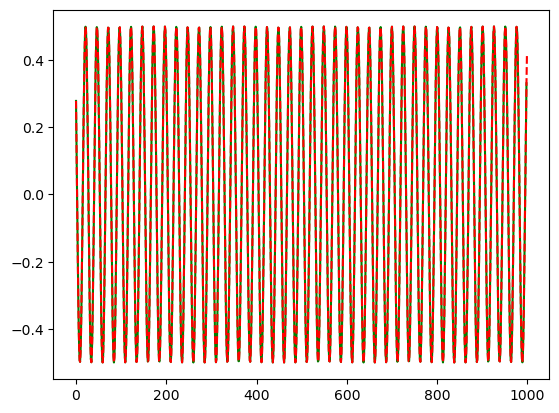

In [141]:
firstSteps = 1000

train = 3000
test = 1000
nrRes = 1000
Nu = 1
np.random.seed(2222)
Win = np.random.uniform(-1, 1, (nrRes,Nu + 1)) * 0.2
W = np.random.uniform(-1, 1, (nrRes,nrRes)) 
# normalizing and setting spectral radius (correct, slow):
#rhoW = max(abs(linalg.eig(W)[0]))
rhoW = max(abs(linalg.eig(W)[0]))
W = (W / rhoW) * 0.8

# allocated memory for the design (collected states) matrix
X = np.zeros((1+1+nrRes,train-firstSteps))
# set the corresponding target matrix directly
Yt = xdata[None,firstSteps+1:train+1] 

# run the reservoir with the data and collect X
x = np.zeros((nrRes,1))
for t in range(train):
    u = xdata[t]
    x = np.tanh( np.dot( Win, np.vstack((1,u)) ) + np.dot( W, x ) )
    if t >= firstSteps:
        X[:,t-firstSteps] = np.vstack((1,u,x))[:,0]
    
# train the output by ridge regression
reg = 1e-8  # regularization coefficient

Wout = linalg.solve( np.dot(X,X.T) + reg*np.eye(1+1+nrRes), 
    np.dot(X,Yt.T) ).T

# run the trained ESN in a generative mode. no need to initialize here, 
# because x is initialized with training data and we continue from there.
Y = np.zeros((1,test))
u = xdata[train]
for t in range(test):
    x = np.tanh( np.dot( Win, np.vstack((1,u)) ) + np.dot( W, x ) )
    y = np.dot( Wout, np.vstack((1,u,x)) )
    Y[:,t] = y
    # generative mode:
    u = y
    ## this would be a predictive mode:
    #u = Xtest[t]   

# compute MSE for the first errorLen time steps
mse = sum( np.square( xdata[train:] - 
    Y[0,0:test] ) ) / test
print('MSE = ' + str( mse ))
plt.plot( xdata[train+1:], 'g' )
plt.plot( Y[0,0:test], '--r' )
plt.show()


In [142]:
def mackey_glass(tau, length):
    betta=0.2
    gamma = 0.1 
    a=10
    delay=100 # will cut these initial steps
    
    y=np.random.rand(tau) # random intial values between 0 and 1
    # Euler's method to solve the differential equation
    for t in range(tau-1, length+delay+tau-1):
        current= y[t] + ( betta * y[t-(tau-1)]   / ( 1 + np.power(y[t-(tau-1)], a) 
)  ) - gamma*y[t]   
        y=np.append(y, current)
    
    y=y-1 # get rid of mean
    y=np.tanh(y) # squeze with tanh    
    
    return y[tau+delay:length+delay+tau] # return the last length elements



MSE = 0.12179496140284059


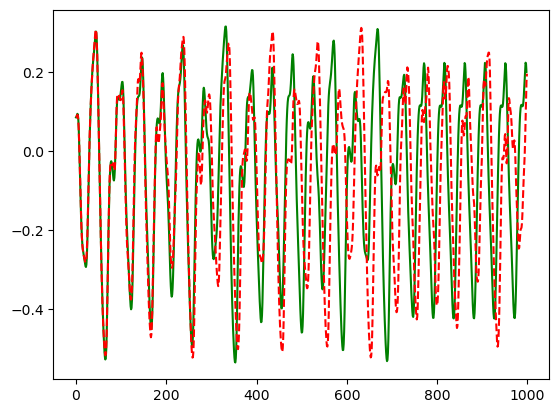

In [143]:
firstSteps = 1000

train = 3000
test = 1000
nrRes = 1000
Nu = 1
np.random.seed(51)
Win = np.random.uniform(-1, 1, (nrRes,Nu + 1)) * 0.2
W = np.random.uniform(-1, 1, (nrRes,nrRes)) 
y2 = mackey_glass(17, 4000)
# normalizing and setting spectral radius (correct, slow):
#rhoW = max(abs(linalg.eig(W)[0]))
rhoW = max(abs(linalg.eig(W)[0]))
W *= 0.8 / rhoW

# allocated memory for the design (collected states) matrix
X  = np.zeros((1+Nu+nrRes,train-firstSteps))
# set the corresponding target matrix directly
Yt = y2[None,firstSteps+1:train+1] 

# run the reservoir with the data and collect X
x = np.zeros((nrRes,1))
for t in range(train):
    u = y2[t]
    x = np.tanh( np.dot( Win, np.vstack((1,u)) ) + np.dot( W, x ) )
    if t >= firstSteps:
        X[:,t-firstSteps] = np.vstack((1,u,x))[:,0]
    
# train the output by ridge regression
reg = 1e-9  # regularization coefficient

Wout = linalg.solve( np.dot(X,X.T) + reg*np.eye(1 +Nu +nrRes), 
    np.dot(X,Yt.T) ).T

# run the trained ESN in a generative mode. no need to initialize here, 
# because x is initialized with training data and we continue from there.
Y = np.zeros((1,test))
u = y2[train]
for t in range(test):
    x = np.tanh( np.dot( Win, np.vstack((1,u)) ) + np.dot( W, x ) )
    y = np.dot( Wout, np.vstack((1,u,x)) )
    Y[:,t] = y
    # generative mode:
    u = y
    ## this would be a predictive mode:
    #u = Xtest[t]

# run the trained ESN in a generative mode. no need to initialize here, 
# because x is initialized with training data and we continue from there.

# compute MSE for the first errorLen time steps
mse = sum( np.square( y2[:test] - 
    Y[0,0:test] ) ) / test
print('MSE = ' + str( mse ))
plt.plot( y2[train + 1:], 'g' )
plt.plot( Y.T, '--r' )
plt.show()


Computing spectral radius...
done.
MSE = 0.017990554111337237


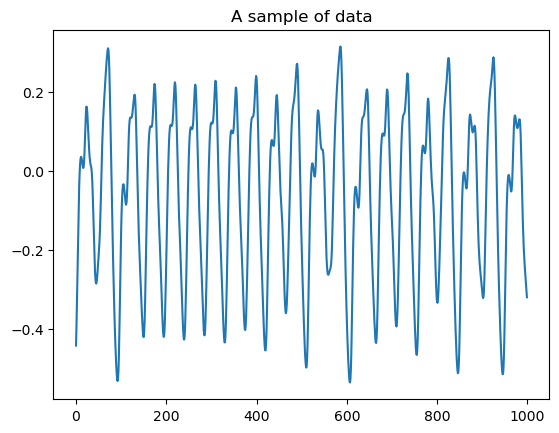

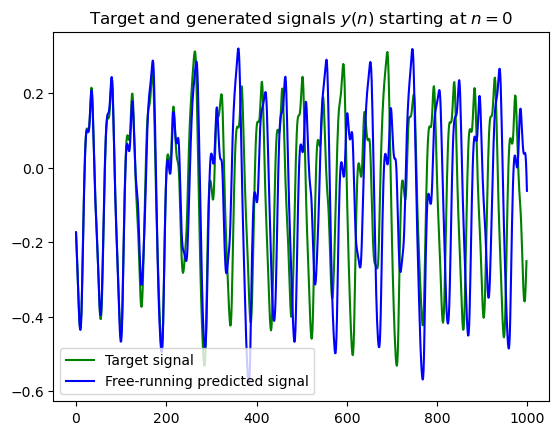

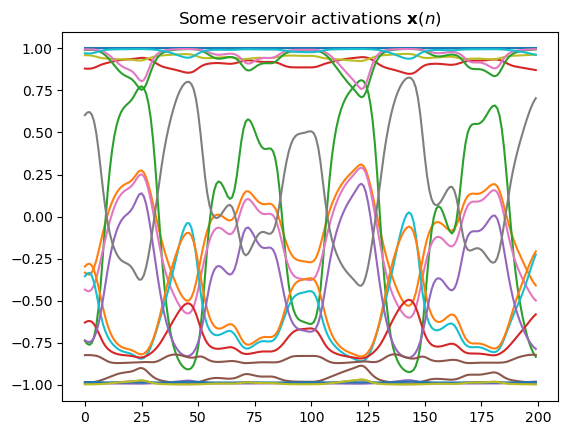

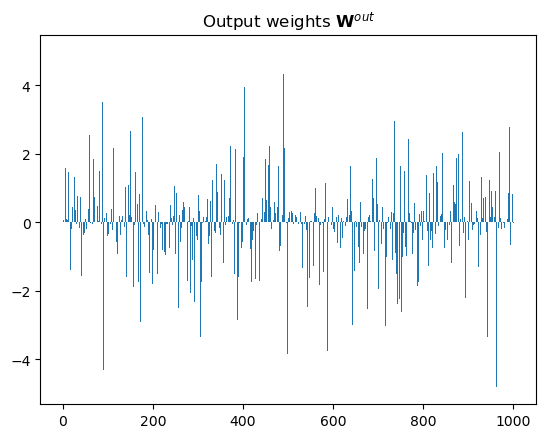

In [144]:
# -*- coding: utf-8 -*-
"""
A minimalistic Echo State Networks demo with Mackey-Glass (delay 17) data 
in "plain" scientific Python.
from https://mantas.info/code/simple_esn/
(c) 2012-2020 Mantas LukoÅ¡eviÄius
Distributed under MIT license https://opensource.org/licenses/MIT
"""
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg 
# numpy.linalg is also an option for even fewer dependencies

# load the data
trainLen = 3000
testLen = 1000
initLen = 1000
data = mackey_glass(17, 4000)

# plot some of it
plt.figure(10).clear()
plt.plot(data[:1000])
plt.title('A sample of data')

# generate the ESN reservoir
inSize = outSize = 1
resSize = 1000
a = 1 # leaking rate
np.random.seed(42)
#scalling =2
Win = (np.random.rand(resSize,1+inSize) - 0.5)/0.2
W = (np.random.rand(resSize,resSize) - 0.5 )
# normalizing and setting spectral radius (correct, slow):
print('Computing spectral radius...')
rhoW = max(abs(linalg.eig(W)[0]))
print('done.')
W *= 0.8 / rhoW

# allocated memory for the design (collected states) matrix
X = np.zeros((1+inSize+resSize,trainLen-initLen))
# set the corresponding target matrix directly
Yt = data[None,initLen+1:trainLen+1] 

# run the reservoir with the data and collect X
x = np.zeros((resSize,1))
for t in range(trainLen):
    u = data[t]
    x = np.tanh( np.dot( Win, np.vstack((1,u)) ) + np.dot( W, x ) )
    if t >= initLen:
        X[:,t-initLen] = np.vstack((1,u,x))[:,0]
    
# train the output by ridge regression
reg = 1e-8  # regularization coefficient
# direct equations from texts:
#X_T = X.T
#Wout = np.dot( np.dot(Yt,X_T), linalg.inv( np.dot(X,X_T) + \
#    reg*np.eye(1+inSize+resSize) ) )
# using scipy.linalg.solve:
Wout = linalg.solve( np.dot(X,X.T) + reg*np.eye(1+inSize+resSize), 
    np.dot(X,Yt.T) ).T

# run the trained ESN in a generative mode. no need to initialize here, 
# because x is initialized with training data and we continue from there.
Y = np.zeros((outSize,testLen))
u = data[trainLen]
for t in range(testLen):
    x = np.tanh( np.dot( Win, np.vstack((1,u)) ) + np.dot( W, x ) )
    y = np.dot( Wout, np.vstack((1,u,x)) )
    Y[:,t] = y
    # generative mode:
    u = y
    ## this would be a predictive mode:
    #u = data[trainLen+t+1] 

# compute MSE for the first errorLen time steps
errorLen = 500
mse = sum( np.square( data[trainLen+1:trainLen+errorLen+1] - 
    Y[0,0:errorLen] ) ) / errorLen
print('MSE = ' + str( mse ))
    
# plot some signals
plt.figure(1).clear()
plt.plot( data[trainLen+1:trainLen+testLen+1], 'g' )
plt.plot( Y.T, 'b' )
plt.title('Target and generated signals $y(n)$ starting at $n=0$')
plt.legend(['Target signal', 'Free-running predicted signal'])

plt.figure(2).clear()
plt.plot( X[0:20,0:200].T )
plt.title(r'Some reservoir activations $\mathbf{x}(n)$')

plt.figure(3).clear()
plt.bar( np.arange(1+inSize+resSize), Wout[0].T )
plt.title(r'Output weights $\mathbf{W}^{out}$')

plt.show()


In [145]:
import numpy as np
dataTest = np.genfromtxt(fname="dataset/SwedishLeaf_TRAIN.tsv")  

print(data.shape) 

(4000,)


In [146]:
import numpy as np
dataTrain = np.genfromtxt(fname="dataset/SwedishLeaf_TEST.tsv")  

print(data.shape) 

(4000,)


In [147]:
dataTest = dataTest.flatten()
dataTrain = dataTrain.flatten()
print("Training data is: ",dataTrain)
print("Test data is: ",dataTest)


Training data is:  [10.         2.20028    1.82008   ...  1.4710899  1.5940799  1.6978799]
Test data is:  [4.        1.5247497 1.5381197 ... 1.6190299 1.81512   1.99143  ]


In [148]:
# normalizing and setting spectral radius (correct, slow):
#rhoW = max(abs(linalg.eig(W)[0]))
rhoW = max(abs(linalg.eig(W)[0]))
W *= 0.99 / rhoW

# allocated memory for the design (collected states) matrix
X  = np.zeros((1+Nu+nrRes,train))
# set the corresponding target matrix directly
Yt = dataTrain[None,1:train+1] 

# run the reservoir with the data and collect X
x = np.zeros((nrRes,1))
for t in range(train):
    u = dataTrain[t]
    x = np.tanh( np.dot( Win, np.vstack((1,u)) ) + np.dot( W, x ) )
    X[:,t] = np.vstack((1,u,x))[:,0]
    
# train the output by ridge regression
reg = 1e-8  # regularization coefficient

Wout = linalg.solve( np.dot(X,X.T) + reg*np.eye(1 +Nu +nrRes), 
    np.dot(X,Yt.T) ).T

print(Wout)

[[-5.51990758e+03 -5.00304486e+00  5.91495308e+00 ...  3.80990152e+01
  -1.09392056e+01  1.14930011e+02]]


In [149]:
Y = np.zeros((1,test))
u = dataTest[0]
test=len(dataTrain)

for t in range(test):
    x = np.tanh( np.dot( Win, np.vstack((1,u)) ) + np.dot( W, x ) )
    y = np.dot( Wout, np.vstack((1,u,x)) )
    Y[:,t] = y
    # generative mode:
    u = y
    ## this would be a predictive mode:
    #u = Xtest[t]
# compute MSE for the first errorLen time steps
mse = sum( np.square( dataTrain[0:] - 
    Y[0,0:test] ) ) / test
print('MSE = ' + str( mse ))

plt.show()

IndexError: index 1000 is out of bounds for axis 1 with size 1000